In [1]:
from os import listdir
from numpy import asarray
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
from numpy import load
from matplotlib import pyplot

In [4]:
def load_images(path, size = (256, 512)):
    source, target = [], []
    for filename in tqdm(listdir(path)):
        img = img_to_array(load_img(path + filename, target_size=size))
        sourcei, targeti = img[:, :256], img[:, 256:]
        source.append(sourcei)
        target.append(targeti)

    return [asarray(source), asarray(target)]

In [5]:
train_path = 'maps/train/'
test_path = 'maps/val/'
[trsource, trtarget] = load_images(train_path)
[tesource, tetarget] = load_images(test_path)
train_file = 'maps_train_256x512.npz'
test_file = 'maps_test_256x512.npz'
savez_compressed(train_file, trsource, trtarget)
savez_compressed(test_file, tesource, tetarget)

100%|██████████| 1098/1098 [00:13<00:00, 82.25it/s]


In [6]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [7]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    mimg = Input(shape=image_shape)
    nmimg = Input(shape=image_shape)

    merged = Concatenate()([mimg, nmimg])

    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([mimg, nmimg], patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [8]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [9]:
def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [10]:
def define_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

In [11]:
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    source = Input(shape=image_shape)
    gen_out = g_model(source)
    dis_out = d_model([source, gen_out])

    model = Model(source, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

In [12]:
def load_real_samples(filename):
    data = load(filename)
    source, target = data['arr_0'], data['arr_1']
    source = (source - 127.5) / 127.5
    target = (target - 127.5) / 127.5
    return [source, target]

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [14]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [15]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])

    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [16]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=10):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs

    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        if(i + 1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [17]:
train_dataset = load_real_samples(train_file)
image_shape = train_dataset[0].shape[1:]

In [18]:
g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

2023-02-12 09:33:06.163592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train(d_model, g_model, gan_model, train_dataset)

In [20]:
from numpy import expand_dims
from keras.models import load_model

In [22]:
test_dataset = load_real_samples(test_file)
tesource, tetarget = test_dataset
model = load_model('model_005450.h5')
prediction = model.predict(tesource)
prediction = (prediction + 1) / 2.0

35/35 [==============================] - 112s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


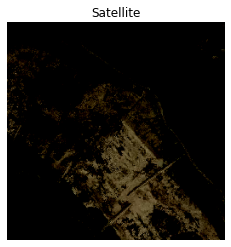

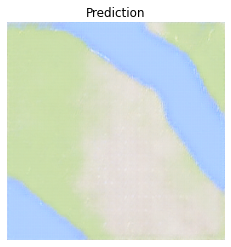

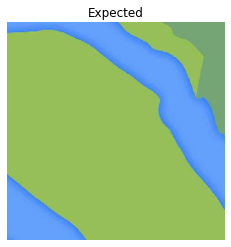

In [28]:
index = 29

pyplot.imshow(tesource[index])
pyplot.axis('off')
pyplot.title('Satellite')
pyplot.show()

pyplot.imshow(prediction[index])
pyplot.axis('off')
pyplot.title('Prediction')
pyplot.show()

pyplot.imshow(tetarget[index])
pyplot.axis('off')
pyplot.title('Expected')
pyplot.show()